In [26]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

In [27]:
rho = 1
mu = 1
u_in = 1
D = 1
L = 1
tle = 10
v_i = 1.5
tau_0 = 10

In [41]:
Q = v_i * np.pi * ((D - 2) - 1) ** 2
Q

18.84955592153876

In [28]:
# geom = dde.geometry.Rectangle(xmin=[-L/2,-D/2],xmax=[L/2,D/2])
geom = dde.geometry.Rectangle(xmin=[-L/2,-D/2],xmax=[L/2,D/2])

In [29]:
def upper_wall(X, on_boundary):
  on_upper_wall = np.logical_and(np.isclose(X[1],D/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_upper_wall

def lower_wall(X, on_boundary):
  on_lower_wall = np.logical_and(np.isclose(X[1],-D/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_lower_wall

def boundary_inlet(X,on_boundary):
  on_inlet = np.logical_and(np.isclose(X[0],-L/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_inlet

def boundary_outlet(X,on_boundary):
  on_outlet = np.logical_and(np.isclose(X[0],L/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_outlet

In [30]:
bc_wall_u = dde.DirichletBC(geom, lambda X:v_i, upper_wall, component =0)
bc_wall_u = dde.DirichletBC(geom, lambda X:0., lower_wall, component =0)
bc_wall_v = dde.DirichletBC(geom, lambda X:0., upper_wall, component =1)
bc_wall_v = dde.DirichletBC(geom, lambda X:0., lower_wall, component =1)

bc_inlet_u = dde.DirichletBC(geom, lambda X:u_in, boundary_inlet, component =0)
bc_inlet_v = dde.DirichletBC(geom, lambda X:0., boundary_inlet, component =1)

bc_outlet_p = dde.DirichletBC(geom, lambda X:0., boundary_outlet, component =2)
bc_outlet_v = dde.DirichletBC(geom, lambda X:0., boundary_outlet, component =1)

In [55]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)
    # du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    # du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    # dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    # dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)

    # Definições para Bingham para componentes do tensor de tensão
    print(type(mu * (du_y + dv_x)))
    tau_xy = tau_0 + mu * (du_y + dv_x)
    tau_yx = tau_0 + mu * (dv_x + du_y)
    tau_xx = tau_0 + mu * (du_x + du_x)
    tau_yy = tau_0 + mu * (dv_y + du_y)

    # Derivadas dos tensores de tensão
    dtau_xy_y = dde.grad.jacobian(tau_xy, X, i=0, j=1)
    dtau_yx_x = dde.grad.jacobian(tau_yx, X, i=0, j=0)
    dtau_xx_x = dde.grad.jacobian(tau_xx, X, i=0, j=0)
    dtau_yy_y = dde.grad.jacobian(tau_yy, X, i=0, j=1)

    # Equações de Navier-Stokes modificadas para incluir todos os tensores de tensão
    pde_u = rho * (Y[:,0:1] * du_x + Y[:,1:2] * du_y) + dp_x - dtau_yx_x - dtau_xx_x
    pde_v = rho * (Y[:,0:1] * dv_x + Y[:,1:2] * dv_y) + dp_y - dtau_xy_y - dtau_yy_y
    pde_cont = du_x + dv_y  # Equação de continuidade

    return [pde_u, pde_v, pde_cont]

In [32]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u,bc_wall_v,bc_inlet_u,bc_inlet_v,bc_outlet_p,bc_outlet_v],
                    num_domain = 2000,
                    num_boundary = 2000,
                    num_test = 2000)

<function matplotlib.pyplot.show(close=None, block=None)>

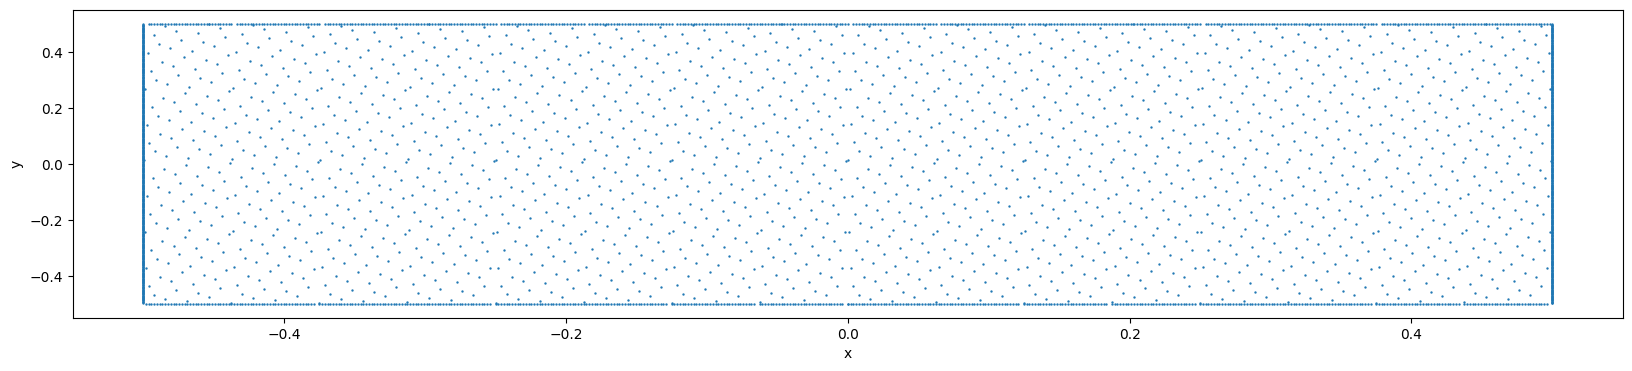

In [33]:
plt.figure(figsize=(20,4))
plt.scatter(data.train_x_all[:,0],data.train_x_all[:,1],s=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show

In [34]:
net = dde.maps.FNN([2]+[64]*5+[3], "tanh","Glorot uniform")

In [35]:
model = dde.Model(data,net)
model.compile("adam",lr=1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.073729 s



c:\Users\Pablo\AppData\Local\pypoetry\Cache\virtualenvs\deepxde-custom-4PBOT-FI-py3.10\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.539685 s



In [36]:
losshistory,train_state = model.train(epochs = 10000)

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [4.81e-03, 1.37e-01, 2.25e-01, 2.84e-02, 1.89e-02, 8.12e-01, 5.98e-03, 8.40e-03, 6.01e-03]    [3.61e-03, 1.28e-01, 2.34e-01, 2.84e-02, 1.89e-02, 8.12e-01, 5.98e-03, 8.40e-03, 6.01e-03]    []  
1000      [5.39e-03, 4.31e-03, 2.96e-03, 3.94e-02, 1.06e-03, 9.50e-02, 7.08e-03, 5.19e-04, 2.84e-03]    [4.16e-03, 3.11e-03, 1.94e-03, 3.94e-02, 1.06e-03, 9.50e-02, 7.08e-03, 5.19e-04, 2.84e-03]    []  
2000      [8.11e-03, 4.36e-02, 3.86e-03, 4.80e-02, 1.09e-03, 5.24e-02, 4.02e-03, 5.51e-04, 5.02e-03]    [8.38e-03, 3.80e-02, 3.34e-03, 4.80e-02, 1.09e-03, 5.24e-02, 4.02e-03, 5.51e-04, 5.02e-03]    []  
3000      [1.32e-03, 5.93e-03, 3.26e-03, 2.52e-02, 1.77e-03, 5.76e-02, 2.81e-03, 2.13e-04, 7.55e-03]    [1.63e-03, 5.58e-03, 2.64e-03, 2.52e-02, 1.77e-03, 5.76e-0

In [37]:
dde.optimizers.config.set_LBFGS_options(maxiter = 30)
model.compile("L-BFGS")
losshistory,train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False , isplot = False)

Compiling model...
'compile' took 2.369477 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
10000     [7.35e-04, 7.61e-04, 2.80e-03, 1.56e-02, 1.74e-03, 4.53e-02, 1.45e-03, 1.75e-04, 4.16e-03]    [7.18e-04, 7.91e-04, 2.94e-03, 1.56e-02, 1.74e-03, 4.53e-02, 1.45e-03, 1.75e-04, 4.16e-03]    []  
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  Objective function value: 0.071741
  Number of iterations: 30
  Number of functions evaluations: 32
10032     [7.37e-04, 1.26e-03, 3.09e-03, 1.51e-02, 1.91e-03, 4.39e-02, 1.57e-03, 2.26e-04, 4.03e-03]    [9.36e-04, 1.35e-03, 3.27e-03, 1.51e-02, 1.91e-03, 4.39e-02, 1.57e-03, 2.26e-04, 4.03e-03]    []  

Best model at step 10032:
  train loss: 7.17e-02
  test loss: 7.22e-02
  test metric: []

'train' took 13.874699 s


In [38]:
samples= geom.random_points(500000)
result = model.predict(samples)

C:\Users\Pablo\AppData\Local\Temp\ipykernel_2556\881912642.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(samples[mask,1], result[mask,0], cmap='viridis',s=2)


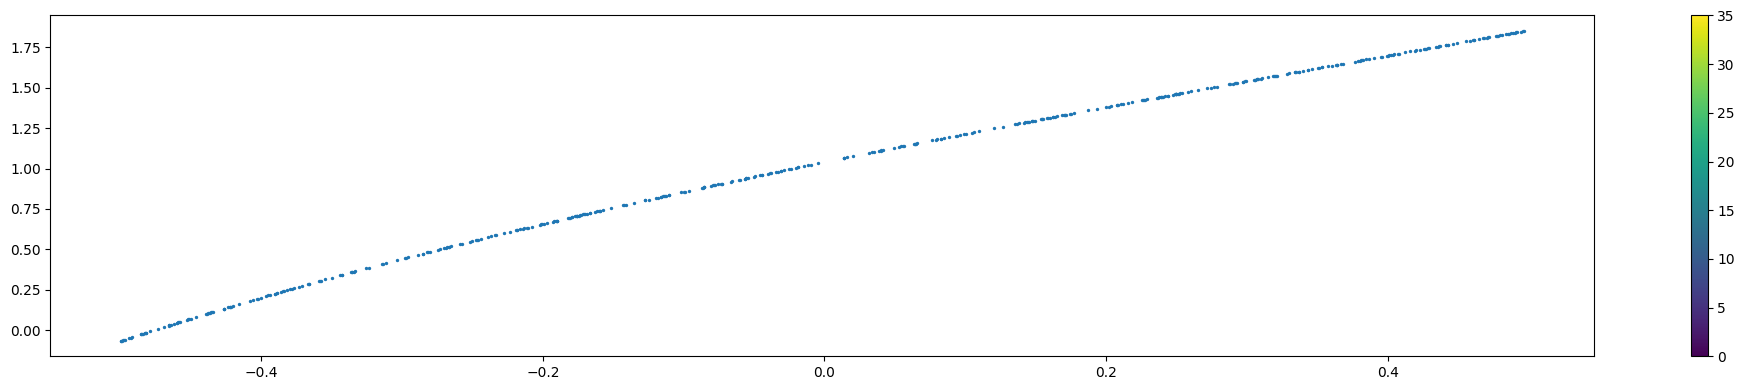

In [64]:
color_legend=[[0,1.5],[-0.3,0.3],[0,35]]
# for idx in range(3):
plt.figure(figsize=(20,4))
mask = np.where((samples[:,0] > 0.42) & (samples[:,0] < 0.421))
# plt.scatter(samples[mask,0], samples[mask,1], c=result[mask,2], cmap='viridis',s=2)
plt.scatter(samples[mask,1], result[mask,0], cmap='viridis',s=2)
plt.colorbar()
plt.clim(color_legend[2])
# plt.xlim((0,D+1))
# plt.xlim((0-L/2,L-L/2))
plt.tight_layout()
plt.show()

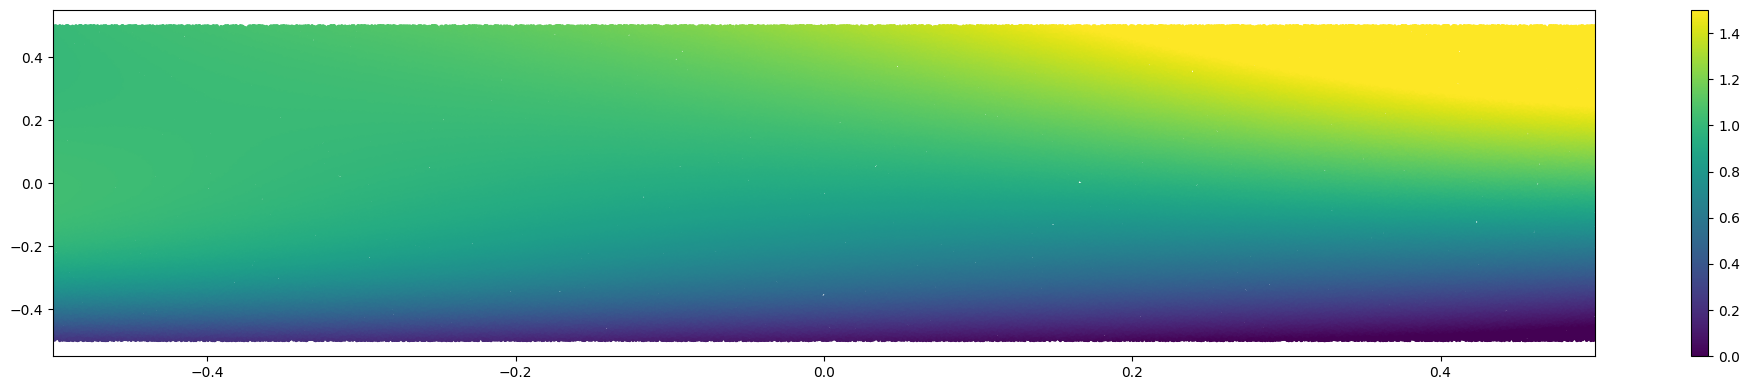

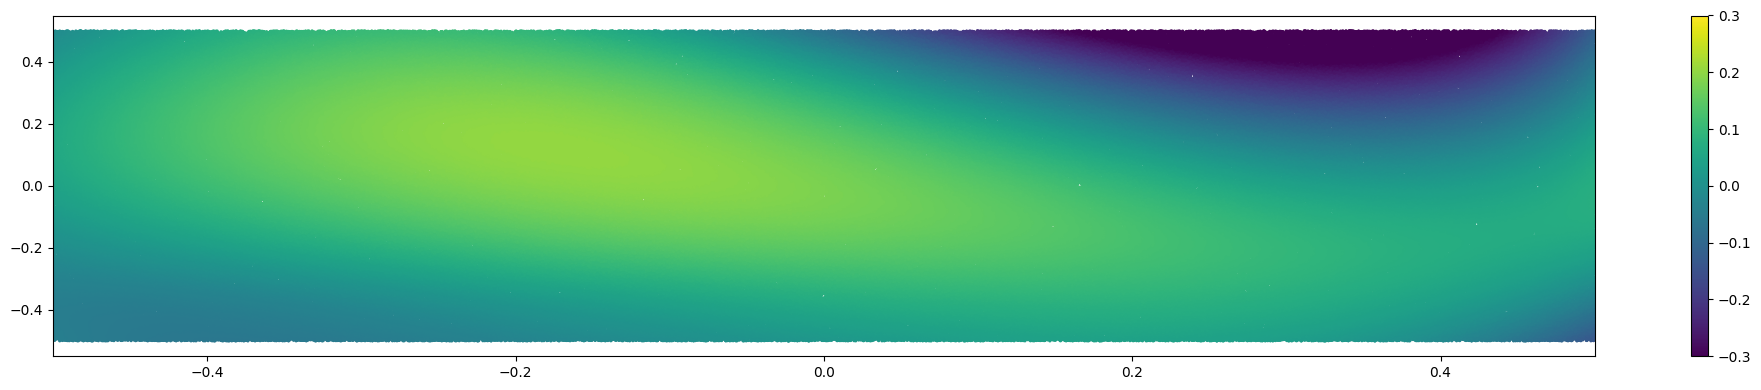

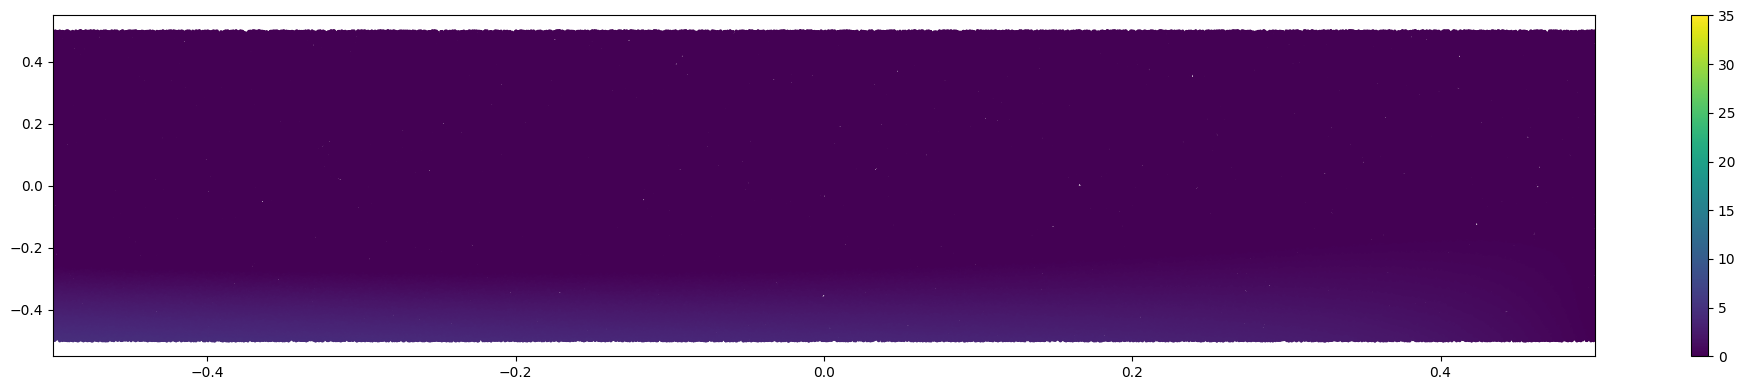

In [39]:
color_legend=[[0,1.5],[-0.3,0.3],[0,35]]
for idx in range(3):
  plt.figure(figsize=(20,4))
  plt.scatter(samples[:,0], samples[:,1], c=result[:,idx], cmap='viridis',s=2)
  plt.colorbar()
  plt.clim(color_legend[idx])
  plt.xlim((0-D/2,D-D/2))
  plt.xlim((0-L/2,L-L/2))
  plt.tight_layout()
  plt.show()